# **Generative Adversarial Networks (GAN)**

### Dr. Santosh Chapaneri
### Lead AI Product Engineer, Wolters Kluwer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Input,Dense,Flatten,Conv2DTranspose
from keras.layers import BatchNormalization, LeakyReLU,Reshape
import tensorflow as tf

In [2]:
# Load in the data.
(X_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize to [-1, 1]
X_train = X_train.astype(np.float32) / 127.5 - 1

# Reshape the data
X_train = np.expand_dims(X_train, axis=3)

print(X_train.shape)

(60000, 28, 28, 1)


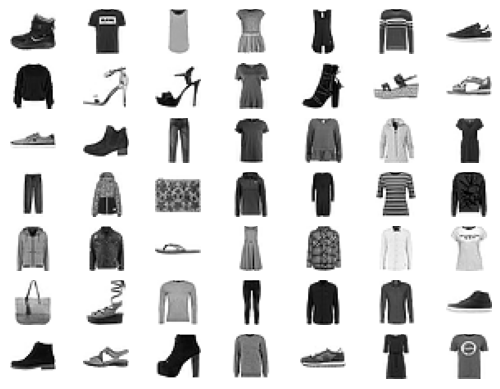

In [3]:
from math import sqrt

def show_plot(data, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		plt.subplot(int(sqrt(n_examples)), int(sqrt(n_examples)), 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(data[i, :, :, 0], cmap='gray_r')
	plt.show()

show_plot(X_train, n_examples = 49)

In [4]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size).prefetch(1)

**Generator**

In [12]:
generator = Sequential()

generator.add(Input(shape=[100]))

generator.add(Dense(512))
generator.add(LeakyReLU(negative_slope=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(256))
generator.add(LeakyReLU(negative_slope=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(128))
generator.add(LeakyReLU(negative_slope=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

In [13]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        51,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,656 (1.22 MB)

 Trainable params: 318,864 (1.22 MB)

 Non-trainable params: 1,792 (7.00 KB)

**Discriminator**

In [14]:
discriminator = Sequential()

discriminator.add(Input(shape=[28,28,1]))
discriminator.add(Flatten())

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(negative_slope=0.2))
discriminator.add(Dropout(0.5))

discriminator.add(Dense(128))
discriminator.add(LeakyReLU(negative_slope=0.2))
discriminator.add(Dropout(0.5))

discriminator.add(Dense(64))
discriminator.add(LeakyReLU(negative_slope=0.2))
discriminator.add(Dropout(0.5))

discriminator.add(Dense(1, activation='sigmoid'))

In [15]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,177 (946.00 KB)

 Trainable params: 242,177 (946.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
GAN = Sequential([generator, discriminator])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

In [17]:
GAN.compile(optimizer='adam', loss='binary_crossentropy')

In [27]:
GAN.layers

[<Sequential name=sequential, built=True>,
 <Sequential name=sequential_1, built=True>]

In [28]:
GAN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 28, 28, 1)      │       320,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       242,177 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562,833 (2.15 MB)

 Trainable params: 318,864 (1.22 MB)

 Non-trainable params: 243,969 (953.00 KB)

In [29]:
epochs = 30
noise_shape = 100

In [30]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10,10))

    for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [31]:
test_input = tf.random.normal(shape=(batch_size, noise_shape))

In [32]:
from tqdm import tqdm
from IPython import display

def train_gan(gan, dataset, batch_size, noise_shape, epochs=5):
    generator, discriminator = gan.layers

    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch+1, epochs))
        for x_batch in dataset:
            noise = tf.random.normal(shape=(batch_size, noise_shape))
            gen_image = generator.predict_on_batch(noise)
            x_fake_and_real = tf.concat([gen_image, x_batch], axis=0)

            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real, y1)

            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, test_input)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, test_input)

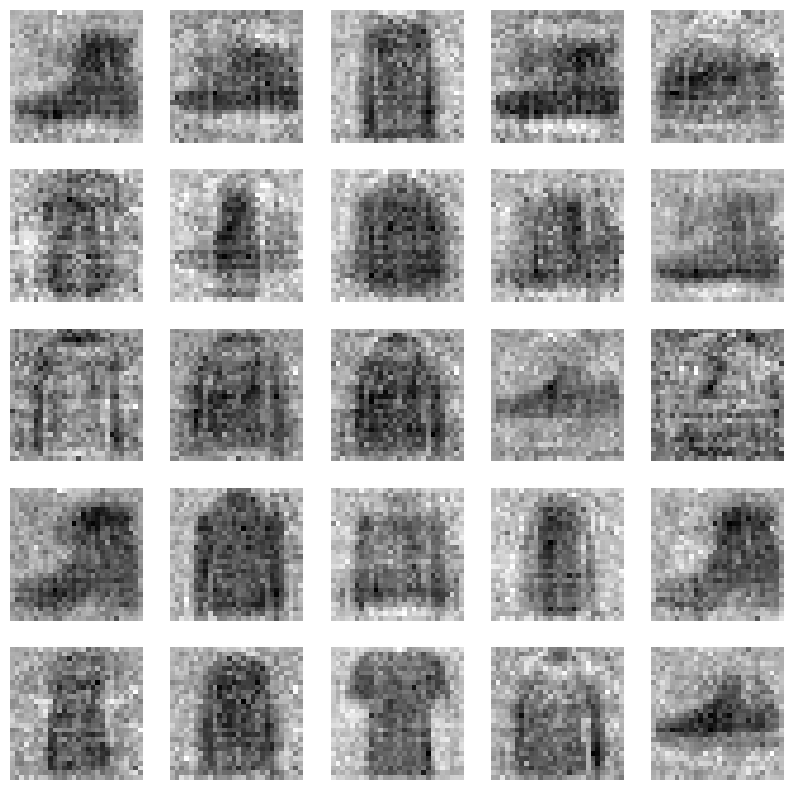

In [41]:
train_gan(GAN, dataset, batch_size, noise_shape, epochs=20)

In [42]:
noise = np.random.normal(size=[10,noise_shape])

gen_image = generator.predict(noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Text(0.5, 1.0, 'How the noise looks')

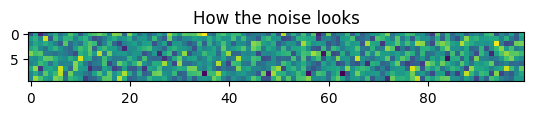

In [43]:
plt.imshow(noise)
plt.title('How the noise looks')

**Generator producing images from noise**

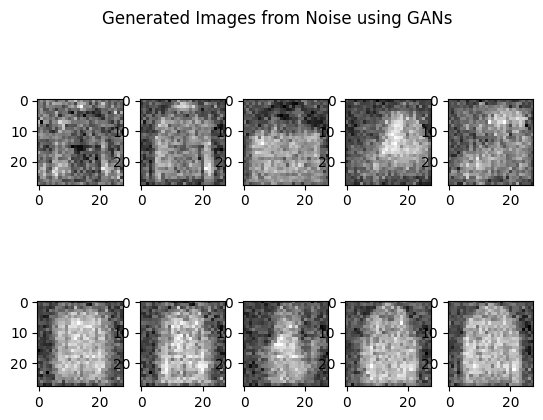

In [44]:
fig,axe = plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1